In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from os.path import join
from os import environ
import os as os

In [2]:
home=environ['HOME']
folder1='GRIMech_CH4_models_RS3_15_trajectories'
folder2='Datasets'
folder3='interpolation'

name_1='State_space_cte_pressure_T1418_st-quarter_phi_'
name_2='Reaction_rates_cte_pressure_T1418_st-quarter_phi_'

end='.csv'

In [3]:
phis=[0.9,1.0,1.10]

In [4]:
def hydrogen_data_clean_shift_grimech_cantera(cantera_species,cantera_sources,maximum_values):
    cantera_sources=cantera_sources.add_suffix('w')
    cantera_sources=cantera_sources.iloc[:,1:] #for taking out the timestep as data 
    
    cantera_time=cantera_species.iloc[:,1]
    cantera_temperature=cantera_species.iloc[:,2]
    cantera_pressure=cantera_species.iloc[:,3]
    
    cantera_species_fractions=cantera_species.iloc[:,4:]
    print(np.shape(cantera_species_fractions))
    
    cantera_species_fractions=cantera_species_fractions.loc[:,(cantera_species!=0).any(axis=0)]
    cantera_species_fractions=cantera_species_fractions.loc[:, (cantera_species != cantera_species.iloc[0]).any()]
    print(np.shape(cantera_species_fractions))
    
    n_columns_mass_fraction=np.shape(cantera_species_fractions)[1]
    print(n_columns_mass_fraction)
    
    cantera_sources=cantera_sources.loc[:,(cantera_sources!=0).any(axis=0)]
    cantera_sources=cantera_sources.loc[:, (cantera_sources != cantera_sources.iloc[0]).any()]
    
    print(np.shape(cantera_sources))
    n_columns_source=np.shape(cantera_sources)[1]
    print(n_columns_source)
    
    cantera_data=pd.concat([cantera_time, cantera_temperature,cantera_species_fractions,cantera_sources],axis=1)

    maximum_values=maximum_values.iloc[:,1:]
    maximum_values=pd.concat([maximum_values.iloc[:,0:2],maximum_values.iloc[:,3:]],axis=1)
    #print(maximum_values)
    
    maximum_values=maximum_values.to_numpy()
    #print(np.shape(maximum_values))
    
    iterations=np.shape(cantera_data)[1]
    
    #cantera_data.divide(maximum_values)
    for j in range(iterations):
        cantera_data.iloc[:,j]=cantera_data.iloc[:,j]/(maximum_values[0,j])
        #print(maximum_values[0,j])
    
    cantera_data_shift=cantera_data.loc[1:,:]
    cantera_data_shift=cantera_data_shift.add_suffix('shift')
    
    cantera_data=cantera_data.reset_index()
    cantera_data_shift=cantera_data_shift.reset_index()
    
    cantera_data=cantera_data.iloc[:,1:]
    cantera_data_shift=cantera_data_shift.iloc[:,1:]

    cantera_data=cantera_data.iloc[0:(np.shape(cantera_data_shift)[0]),:]
    
    data_all=pd.concat([cantera_data, cantera_data_shift], axis=1)

    columns=data_all.columns.to_list()
    
    return data_all, n_columns_source, n_columns_mass_fraction, columns

In [5]:
coefficients=pd.read_csv('cluster1_coefficients.csv').to_numpy()
intercepts=pd.read_csv('cluster1_intercepts.csv').to_numpy()


coefficients=coefficients[:,1:]
intercepts=intercepts[:,1]
print(np.shape(coefficients))
print(np.shape(intercepts))

(31, 172)
(31,)


In [30]:
equivalence_ratios=2 #indices I'm interested in
print(phis[equivalence_ratios])

1.1


In [31]:
cantera_species=pd.read_csv(join(home,folder1,folder2,folder3,name_1+str(equivalence_ratios)+end))
cantera_species=pd.DataFrame(cantera_species)
    
cantera_sources=pd.read_csv(join(home,folder1,folder2,folder3,name_2+str(equivalence_ratios)+end))
cantera_sources=pd.DataFrame(cantera_sources)
    
maximum_values=pd.read_csv(join(home,folder1,folder2,'maximum_values_T1418.csv'))
maximum_values=pd.DataFrame(maximum_values)
    
dataset, n_columns_source, n_columns_mass_fraction, columns=hydrogen_data_clean_shift_grimech_cantera(cantera_species,cantera_sources,maximum_values)
    
n_samples=np.shape(dataset)[0]
attach=np.ones((n_samples,1))*phis[equivalence_ratios]
print(phis[equivalence_ratios])
attach=pd.DataFrame(attach, columns=['Phi'])
dataset=pd.concat([dataset, attach],axis=1)
    
latent_features=['OH', 'CH3OH','CH3', 'H', 'CH2OH','CH4','H2','C','HCO', 'Phi']
    
prediction_features=np.zeros((np.shape(dataset)[0],len(latent_features)))

for m in range(len(latent_features)):
    label=latent_features[m]
    prediction_features[:,m]=dataset.loc[:,label]
            
prediction_features=pd.DataFrame(prediction_features, columns=latent_features)
        
predictions_f=prediction_features
    
basis=prediction_features.iloc[:,:-1].to_numpy()
basis_squared=basis**2
for k in range(len(latent_features)-1): 
    #print(i)
    for j in range(np.shape(basis)[1]):
        #print(j)
        new_features=np.multiply(basis[:,j],prediction_features.iloc[:,k].to_numpy())
        new_features_squared=np.multiply(basis_squared[:,j],prediction_features.iloc[:,k].to_numpy())
        new_features=pd.DataFrame(new_features)
        new_features_squared=pd.DataFrame(new_features_squared)
        predictions_f=pd.concat([predictions_f,new_features,new_features_squared],axis=1)
    
output_start=3+n_columns_mass_fraction+n_columns_source
output_end=output_start+n_columns_mass_fraction+1
Outputs=dataset.iloc[:,output_start:output_end]
    
t_index=columns.index('t[s]shift')
t_trans=maximum_values.columns.get_loc('t[s]')
time_plot=(dataset.iloc[:,t_index])*maximum_values.iloc[0,t_trans]*1e3
    
out_columns=columns[1:2+n_columns_mass_fraction]

mae_errors=np.zeros((1+n_columns_mass_fraction))

n_neg=0
    
for j in range(1+n_columns_mass_fraction):        
    prediction=np.matmul(predictions_f,np.transpose(coefficients[j,:]))+intercepts[j]
    
    original=Outputs.iloc[:,j]#*maximum_values.iloc[0,transformation_index]
    reconstruction=prediction#*maximum_values.iloc[0,transformation_index]

    score=mean_absolute_error(original,reconstruction)
    #if score<0:
        #r2_scores[j]=0
        #n_neg=n_neg+1
    #if score<0.8:
        #print(out_columns[j])
    #else:
    mae_errors[j]=score #r2_score(original,reconstruction)


(120000, 49)
(120000, 30)
30
(120000, 30)
30
1.1


In [32]:
n_neg

0

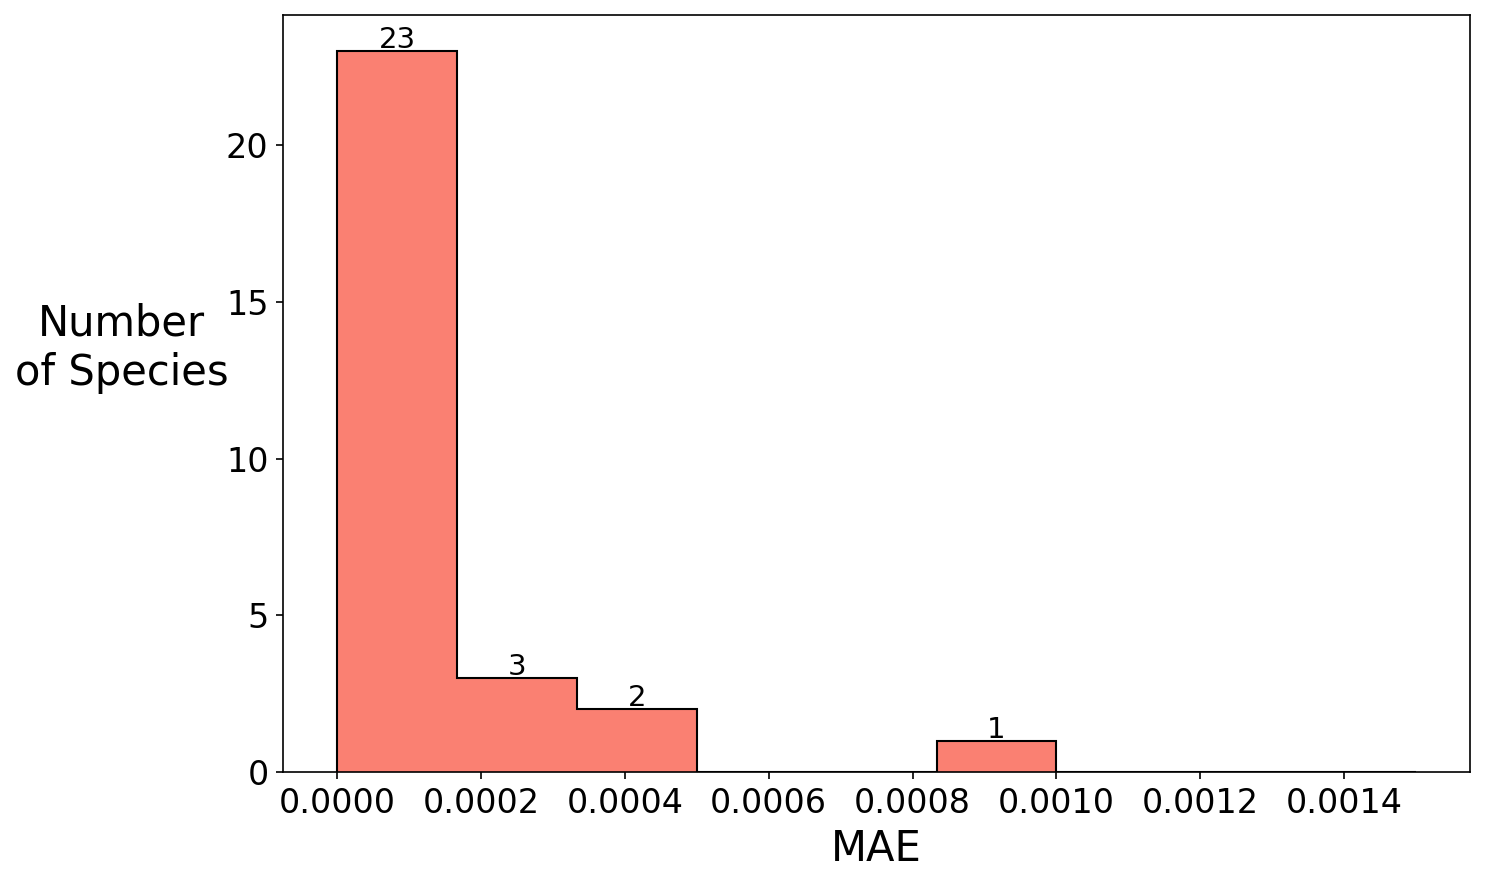

In [33]:
bins1 = np.linspace(0, 0.0015, 10)  # Replace or adjust as needed
counts, bins = np.histogram(mae_errors, bins=bins1)

plt.figure(figsize=(10, 6), dpi=150)

plt.hist(bins1[:-1], bins1, histtype='step', fill=True,
         weights=counts, color='salmon', edgecolor='black')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Number\nof Species', fontsize=20, rotation='horizontal', labelpad=50)
plt.xlabel('MAE', fontsize=20)

for i in range(len(bins1) - 1):
    if counts[i] > 0:
        x = bins1[i] + (bins1[1] - bins1[0]) / 2
        y = counts[i] + 0.1
        plt.text(x, y, str(int(counts[i])), fontsize=14, ha='center')

plt.tight_layout()
plt.savefig('interpolation_MAE_cluster_1' + str(equivalence_ratios) + '.jpg',
            dpi=300, bbox_inches='tight')  # High-res output only at save time

In [34]:
mae_errors

array([1.04604524e-04, 4.81233956e-05, 2.91440133e-05, 1.25169120e-04,
       7.85317319e-05, 6.22859106e-05, 1.27599172e-04, 9.70865424e-04,
       2.54464759e-03, 9.70423792e-06, 9.54188018e-06, 1.05089834e-05,
       1.07461102e-05, 8.25858490e-05, 7.61401736e-05, 2.73985950e-04,
       3.71172084e-04, 4.64217981e-05, 1.61679605e-03, 9.29731561e-06,
       2.38089670e-04, 6.90238857e-05, 8.28343406e-06, 3.52235492e-05,
       1.73585642e-05, 4.63265978e-04, 1.19275481e-04, 2.72480123e-04,
       1.52201441e-05, 2.15686628e-05, 1.48799906e-05])

In [35]:
np.mean(mae_errors)

0.0002542755097208204